출처: 
https://www.kaggle.com/marcuswingen/eda-of-bookings-and-ml-to-predict-cancelations

# Hotel booking

## Content:
### 1. EDA

The dataset contains data from two different hotels. One Resort hotel and one City hotel.

From the publication (https://www.sciencedirect.com/science/article/pii/S2352340918315191) we know that both hotels are located in Portugal (southern Europe) ("H1 at the resort region of Algarve and H2 at the city of Lisbon"). The distance between these two locations is ca. 280 km by car and both locations border on the north atlantic.  

The data contains "bookings due to arrive between the 1st of July of 2015 and the 31st of August 2017".  
Note: For most questions I will only use bookings that were not canceled, to get acutal guest numbers. As you will see, this is quite a big difference.

Topics covered and questions to answer from the data:
- Where do the guests come from?
- How much do guests pay for a room per night?
- How does the price per night vary over the year?
- Which are the most busy month?
- How long do people stay at the hotels?
- Bookings by market segment
- How many bookings were canceled?
- Which month have the highest number of cancelations?

Do you have more questions? Tell me in the comments and I will see if I can answer them. :)


### 2. Predicting cancelations
It would be nice for the hotels to have a model to predict if a guest will actually come.  
This can help a hotel to plan things like personel and food requirements.  
Maybe some hotels also use such a model to offer more rooms than they have to make more money... who knows...

### 3. Evaluate Feature importance
Which features are most important to predict cancelations?  

Setup, data inspection and cleanup are hidden for easier reading. Click the Code/Output buttons if you are curious.

In [1]:
# 설치

# 공통:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import folium

# 머신러닝:
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import eli5 # Feature importance evaluation


# 디스플레이 옵션 설정:
sns.set(style="whitegrid")
pd.set_option("display.max_columns", 36)

# 데이터 불러오기:
file_path = "../input/hotel-booking-demand/hotel_bookings.csv"
full_data = pd.read_csv(file_path)

/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.

/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.

/opt/conda/lib/python3.6/site-packages/sklearn/externals/six.py:31: FutureWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version o

In [2]:
# A bit of data inspection and cleanup, I did most of the inspectin seperately
full_data.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [3]:
# 결측치 확인
full_data.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

In [4]:
# 결측값대체:
# 대리인 :대리점이 없을 경우, 예약은 대리점 없이 이루어졌을 가능성이 크다.
# 회사: 주어진 것이 없다면, 그것은 거의 사적인 것이었을 것이다.
# 휴식은 스스로 조절하는 것이어야 한다.
nan_replacements = {"children:": 0.0, "country":"Unknown", "agent":0,"company":0}
full_data_cln = full_data.fillna(nan_replacements)


# "식사"는 "Undefined"값을 포함하며, 이는 SC와 동일하다
full_data_cln["meal"].replace("Undefined", "SC", inplace=True)

# 일부 행에는 성인 0명, 어린이 0명, 아기 0명이 있는 엔트리가 있다.
# 이 엔트리는 손님이 없는 항목들로 제거한다.
zero_guests = list(full_data_cln.loc[full_data_cln["adults"]
                      +full_data_cln["children"]
                      +full_data_cln["babies"]==0]. index)
full_data_cln.drop(full_data_cln.index[zero_guests], inplace=True)

In [5]:
# 데이터 클렌징 후 데이터 확인
full_data_cln.shape

(119210, 32)

## 1. EDA

In [6]:
rh =full_data_cln.loc[(full_data_cln["hotel"] == "Resort Hotel") & (full_data_cln["is_canceled"]== 0)]
ch =full_data_cln.loc[(full_data_cln["hotel"] == "City Hotel") & (full_data_cln["is_canceled"]== 0)]

In [7]:
# 클렌징 후, Resort 와 City hotel 분리
# 실제 방문자수를 알기 위해, 취소가 포함되지 않는 예약만 분리
rh =full_data_cln.loc[(full_data_cln["hotel"] == "Resort Hotel") & (full_data_cln["is_canceled"]== 0)]
ch =full_data_cln.loc[(full_data_cln["hotel"] == "City Hotel") & (full_data_cln["is_canceled"]== 0)]

### 손님들은 어디에서 오는가?

In [8]:
# 국가별 실제 방문자 수
country_data = pd.DataFrame(full_data_cln.loc[full_data_cln["is_canceled"]== 0]["country"].value_counts())

#country_data.index.name = "country"
country_data.rename(columns={"country":"Number of Guests"}, inplace=True)
total_guests = country_data["Number of Guests"].sum()
country_data["Guests in %"] = round(country_data["Number of Guests"] / total_guests +100, 2)
country_data["country"] = country_data.index
#country_data.loc[country_data['Guests in %']<2, "country"] = "Other"

# 파이 그래프 그리기
fig = px.pie(country_data,
            values="Number of Guests",
            names = "country",
            title = "Home country of guests",
            template = "seaborn")
fig.update_traces(textposition = "inside", textinfo="value+percent+label")
fig.show()

In [9]:
# 지도에 그리기
guest_map = px.choropleth(country_data,
             locations = country_data.index,
             color = country_data["Guests in %"],
             hover_name = country_data.index,
             color_continuous_scale = px.colors.sequential.Plasma,
             title = "Home country of guests")
guest_map.show()

전세계 사람들이 두 호텔에 머물고 있다. 대부분의 손님들은 포루투갈과 유럽의 다른 나라에서 온다.

### 하룻밤에 방값은 얼마?
두 호텔 모두 객실유형과 식사 준비가 다르다. 계절적인 요인도 중요하다. 그래서 가격이 매우 다르다(비싸다?). 통화정보는 제공되지 않지만 포루투갈은 유럽통화동맹의 일부이기 때문에, 모든 가격으 EUR에 있다고 생각한다.

In [10]:
# 성인 및 어린이를 유료 게스트로만 계산(아기 X )
rh["adr_pp"] = rh["adr"]/(rh["adults"] + rh["children"])
ch["adr_pp"] = ch["adr"]/(ch["adults"] + ch["children"])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [11]:
print("""모든 예약, 모든 객실 유형 및 식사 전반에 걸쳐, 평균 가격은 다음과 같습니다.:
Resort hotel: {:.2f} € 1박 및 개인당 
City hotel: {:.2f}€ 1박 및 개인당  """
        .format(rh["adr_pp"].mean(), ch["adr_pp"].mean()))

모든 예약, 모든 객실 유형 및 식사 전반에 걸쳐, 평균 가격은 다음과 같습니다.:
Resort hotel: 47.49 € 1박 및 개인당 
City hotel: 59.27€ 1박 및 개인당  


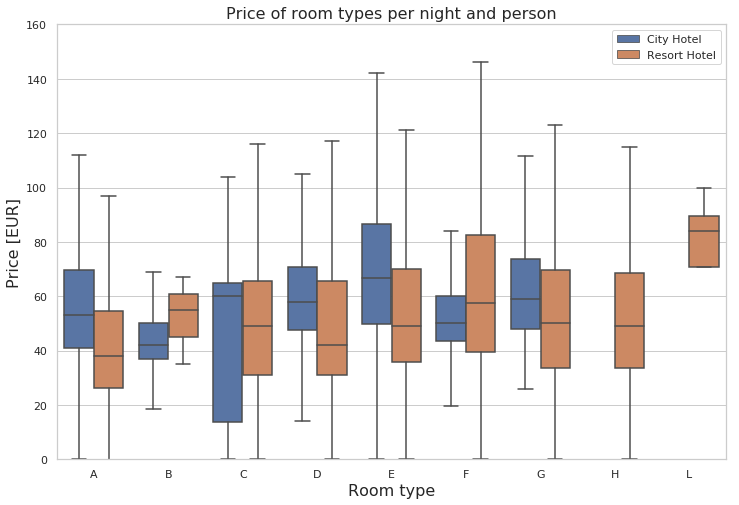

In [12]:
# 1박 가격 normalize(정상화)
full_data_cln["adr_pp"] = full_data_cln["adr"] / (full_data_cln["adults"]+full_data_cln["children"])
full_data_guests = full_data_cln.loc[full_data_cln["is_canceled"]== 0] # 실제 고객만
room_prices = full_data_guests[["hotel", "reserved_room_type","adr_pp"]].sort_values("reserved_room_type")

# boxplot:
plt.figure(figsize=(12,8))
sns.boxplot(x="reserved_room_type",
           y="adr_pp",
           hue="hotel",
           data=room_prices,
           hue_order=["City Hotel","Resort Hotel"],
           fliersize = 0)
plt.title("Price of room types per night and person", fontsize = 16)
plt.xlabel("Room type", fontsize = 16)
plt.ylabel("Price [EUR]", fontsize = 16)
plt.legend(loc="upper right")
plt.ylim(0,160)
plt.show()

이 표는 객실유형과 표준편차에 따른 객실당 평균 가격을 보여준다. data anonymization room으로 인해 유형문자가 동일한 호텔 간에 반드시 동일하지 않을 수 있다.

### 1년간 1박 가격의 변화
간단히 말하면, 객실 종류와 식사에 상관없이 1박과 1인당 평균 가격을 사용하고 있다.

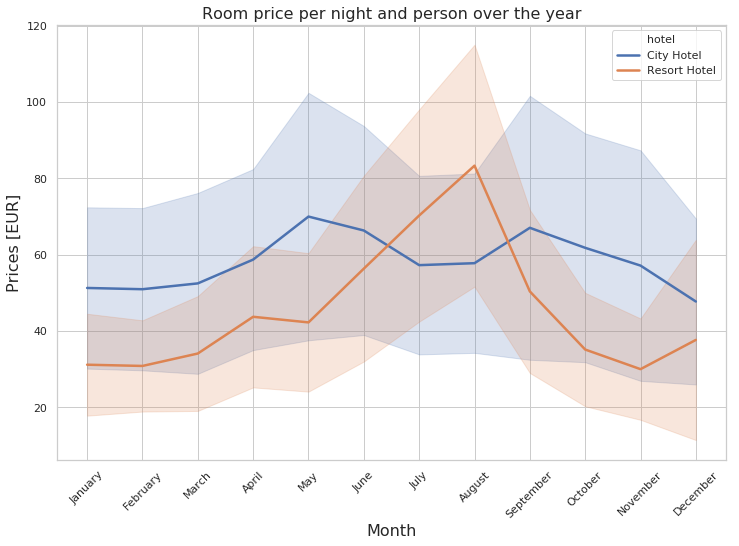

In [13]:
# grab data:
room_prices_monthly = full_data_guests[["hotel","arrival_date_month","adr_pp"]].sort_values("arrival_date_month")

# order by month:
ordered_months = ["January", "February", "March", "April", "May", "June",
               "July", "August", "September", "October", "November", "December"]
room_prices_monthly["arrival_date_month"] = pd.Categorical(room_prices_monthly["arrival_date_month"], categories=ordered_months, ordered=True)

# 표준 편차가 있는 barplot:
plt.figure(figsize=(12,8))
sns.lineplot(x = "arrival_date_month", y="adr_pp", hue="hotel", data=room_prices_monthly, 
            hue_order = ["City Hotel", "Resort Hotel"], ci="sd", size="hotel", sizes=(2.5, 2.5))
plt.title("Room price per night and person over the year", fontsize = 16)
plt.xlabel("Month", fontsize=16)
plt.xticks(rotation=45)
plt.ylabel("Prices [EUR]", fontsize =16)
plt.show()

이것은 리조트 호텔의 가격이 여름 동안 훨씬 더 비싸다는 것을 분명히 보여준다.
City Hotel의 가격은 변동이 적고 봄과 가을에 가장 비싸다.

### Which are the most busy month? (가장 바쁜 달은 언제?)

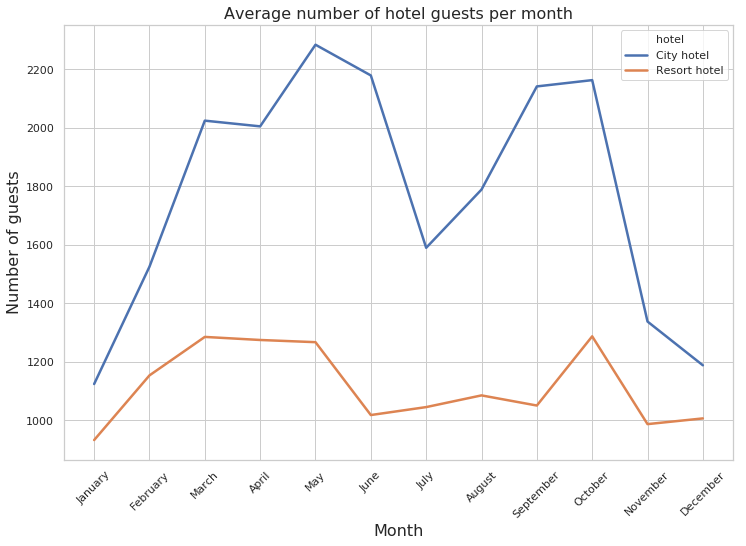

In [14]:
# 연관 데이터로 데이터 프레임 만들기
resort_guests_monthly = rh.groupby("arrival_date_month")["hotel"].count()
city_guests_monthly = ch.groupby("arrival_date_month")["hotel"].count()

resort_guest_data = pd.DataFrame({"month": list(resort_guests_monthly.index),
             "hotel": "Resort hotel",
             "guests" : list(resort_guests_monthly.values)})

city_guest_data = pd.DataFrame({"month": list(city_guests_monthly.index),
             "hotel": "City hotel",
             "guests" : list(city_guests_monthly.values)})
full_guest_data = pd.concat([resort_guest_data, city_guest_data], ignore_index=True)


# order by month
ordered_months =["January", "February", "March", "April", "May", "June",
                "July", "August", "September", "October", "November", "December"]
full_guest_data["month"] = pd.Categorical(full_guest_data["month"], categories=ordered_months, ordered=True)

# Data Set에는 3년 후인 7월과 8월, 2년 후인 다른 달이 포함된다. 데이터 정규화:
full_guest_data.loc[(full_guest_data["month"] == "July") | (full_guest_data["month"] == "August"),
                   "guests"]/= 3
full_guest_data.loc[~((full_guest_data["month"] == "July") | (full_guest_data["month"] == "August")),
                   "guests"]/= 2

# 그래프 :
plt.figure(figsize=(12,8))
sns.lineplot(x= "month", y="guests", hue="hotel", data=full_guest_data,
            hue_order=["City hotel","Resort hotel"], size="hotel",sizes=(2.5,2.5))
plt.title("Average number of hotel guests per month", fontsize = 16)
plt.xlabel("Month", fontsize = 16)
plt.xticks(rotation=45)
plt.ylabel("Number of guests", fontsize =16)
plt.show()

The City hotel은 가격도 비싼 봄과 가을에 손님이 더 많다.
7월과 8월에는 비록 가격은 낮지만 방문객이 적다.

The Resort hotel의 투숙객 수는 6월에서 9월까지 소폭 하락하는데, 이 또한 가격이 가장 높을 때이다.

두 호텔 모두 겨울 동안 손님이 가장 적다.

### How long do people stay at the hotels?(투숙객은 호텔에 얼마나 오래 머물었나?)

In [15]:
rh

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,adr_pp
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,0.0,0.0,0,Transient,0.00,0,0,Check-Out,2015-07-01,0.000000
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,0.0,0.0,0,Transient,0.00,0,0,Check-Out,2015-07-01,0.000000
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,0.0,0.0,0,Transient,75.00,0,0,Check-Out,2015-07-02,75.000000
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,0.0,0,Transient,75.00,0,0,Check-Out,2015-07-02,75.000000
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,0.0,0,Transient,98.00,0,1,Check-Out,2015-07-03,49.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40055,Resort Hotel,0,212,2017,August,35,31,2,8,2,1.0,0,BB,GBR,Offline TA/TO,TA/TO,0,0,0,A,A,1,No Deposit,143.0,0.0,0,Transient,89.75,0,0,Check-Out,2017-09-10,29.916667
40056,Resort Hotel,0,169,2017,August,35,30,2,9,2,0.0,0,BB,IRL,Direct,Direct,0,0,0,E,E,0,No Deposit,250.0,0.0,0,Transient-Party,202.27,0,1,Check-Out,2017-09-10,101.135000
40057,Resort Hotel,0,204,2017,August,35,29,4,10,2,0.0,0,BB,IRL,Direct,Direct,0,0,0,E,E,0,No Deposit,250.0,0.0,0,Transient,153.57,0,3,Check-Out,2017-09-12,76.785000
40058,Resort Hotel,0,211,2017,August,35,31,4,10,2,0.0,0,HB,GBR,Offline TA/TO,TA/TO,0,0,0,D,D,0,No Deposit,40.0,0.0,0,Contract,112.80,0,1,Check-Out,2017-09-14,56.400000


In [16]:
# 관련 데이터로 데이터프레임 만들기:
rh["total_nights"] = rh["stays_in_weekend_nights"]+rh["stays_in_week_nights"]
ch["total_nights"] = ch["stays_in_weekend_nights"]+ch["stays_in_week_nights"]

num_nights_res=list(rh["total_nights"].value_counts().index)# 총 투숙일 수 리스트 만들기
num_bookings_res=list(rh["total_nights"].value_counts())
rel_bookings_res=rh["total_nights"].value_counts()/sum(num_bookings_res)*100 # 비율로 변환

num_nights_city=list(ch["total_nights"].value_counts().index)# 총 투숙일 수 리스트 만들기
num_bookings_city=list(ch["total_nights"].value_counts())
rel_bookings_city=ch["total_nights"].value_counts()/sum(num_bookings_city)*100 # 비율로 변환

res_nights = pd.DataFrame({"hotel":"Resort hotel",
                            "num_nights": num_nights_res,
                            "rel_num_bookings":rel_bookings_res})

city_nights = pd.DataFrame({"hotel":"City hotel",
                            "num_nights": num_nights_city,
                            "rel_num_bookings":rel_bookings_city})

nights_data = pd.concat([res_nights, city_nights], ignore_index=True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



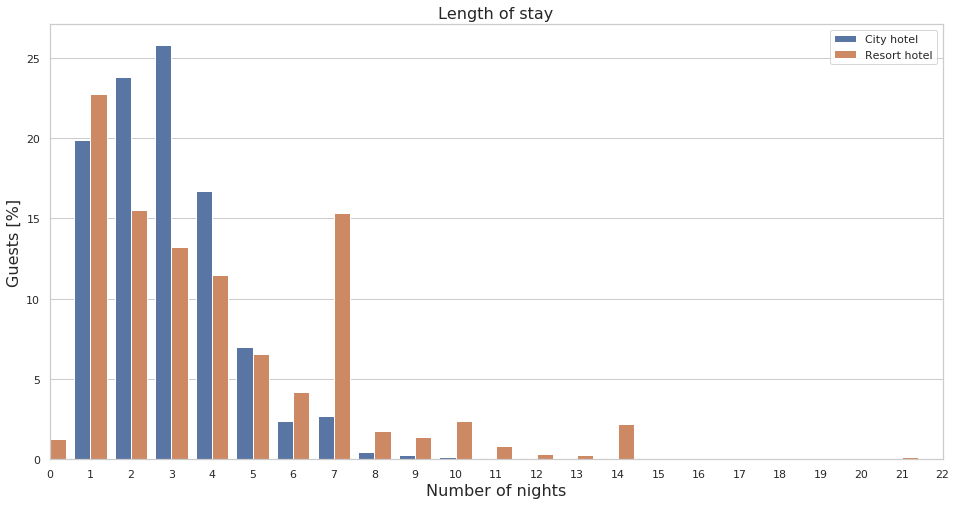

In [17]:
# 그래프로 그리기:
plt.figure(figsize=(16,8))
sns.barplot(x="num_nights", y="rel_num_bookings", hue="hotel", data=nights_data,
           hue_order = ["City hotel", "Resort hotel"])
plt.title("Length of stay", fontsize = 16)
plt.xlabel("Number of nights", fontsize = 16)
plt.ylabel("Guests [%]", fontsize=16)
plt.legend(loc="upper right")
plt.xlim(0,22)
plt.show()

In [18]:
#평균값
avg_nights_res = sum(list((res_nights["num_nights"]*(res_nights["rel_num_bookings"]/100)).values))
avg_nights_city = sum(list((city_nights["num_nights"]*(city_nights["rel_num_bookings"]/100)).values))
print(f"평균적으로, City hotel에 머무는 투숙객은 {avg_nights_city:.2f}밤 이고 최대 {city_nights['num_nights'].max()}밤이다.")
print(f"평균적으로, Resort hotel에 머무는 투숙객은 {avg_nights_res:.2f}밤 이고 최대 {res_nights['num_nights'].max()}밤이다.")

평균적으로, City hotel에 머무는 투숙객은 2.92밤 이고 최대 48밤이다.
평균적으로, Resort hotel에 머무는 투숙객은 4.14밤 이고 최대 69밤이다.


```the City hotel의 경우 1박에서 4박까지 숙박을 선호하는 것으로 보인다
the Resort hotel의 경우 1~4박도 예약되는 경우가 많지만, 7박도 큰 인기를 끌고 있어 눈에 띈다.```

### Bookings by market segment 

In [19]:
# market segment 별 총 예약 수 (incl. cancled)
segments = full_data_cln["market_segment"].value_counts()

In [20]:
# 파이 그래프
fig = px.pie(segments,
            values=segments.values,
            names=segments.index,
            title="Bookings per market segment",
            template= "seaborn")
fig.update_traces(rotation=-90, textinfo="percent+label")
fig.show()

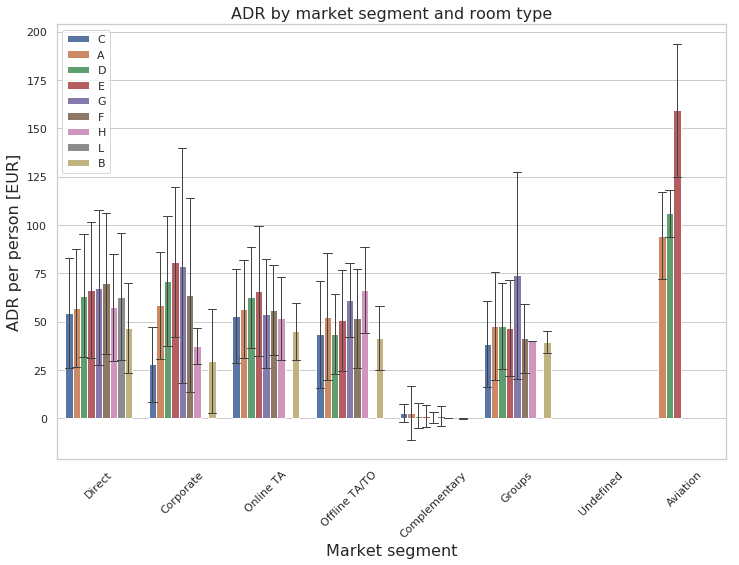

In [21]:
# 예약 및 객실별 1박당 가격(ADR) & 인당 가격
# 그래프 그리기:   
plt.figure(figsize=(12,8))
sns.barplot(x="market_segment",
           y="adr_pp",
           hue="reserved_room_type",
           data=full_data_cln,
           ci="sd",
           errwidth=1,
           capsize=0.1)
plt.title("ADR by market segment and room type", fontsize = 16)
plt.xlabel("Market segment", fontsize = 16)
plt.xticks(rotation=45)
plt.ylabel("ADR per person [EUR]", fontsize = 16)
plt.legend(loc="upper left")
plt.show()

```
평균적으로 단체의 경우, 가장 좋은 가격을 받고 항공사들은 대략 두 배의 돈을 지불한다.
항공사에서 지불한 높은 가격이 가능한 이유는 무엇일까?
```

In [22]:
# 관련 데이터 요약:
Airline_data = full_data_cln.loc[full_data_cln["market_segment"]=="Aviation"][["is_canceled",
                                                               "adults",
                                                               "lead_time",
                                                               "adr_pp",]].describe()

Non_Airline_data = full_data_cln.loc[full_data_cln["market_segment"]!="Aviation"][["is_canceled",
                                                               "adults",
                                                               "lead_time",
                                                               "adr_pp",]].describe()

In [23]:
Airline_data

,is_canceled,adults,lead_time,adr_pp
count,235.000000,235.000000,235.00000,235.000000
mean,0.221277,1.012766,4.47234,100.270979
std,0.415992,0.112503,4.61629,20.376689
min,0.000000,1.000000,0.00000,0.000000
25%,0.000000,1.000000,1.00000,95.000000
50%,0.000000,1.000000,3.00000,95.000000
75%,0.000000,1.000000,6.00000,110.000000
max,1.000000,2.000000,23.00000,193.500000


In [24]:
Non_Airline_data

,is_canceled,adults,lead_time,adr_pp
count,118975.000000,118975.000000,118975.000000,118971.000000
mean,0.371061,1.860878,104.306031,55.038212
std,0.483091,0.574499,106.888885,29.016998
min,0.000000,0.000000,0.000000,-3.190000
25%,0.000000,2.000000,18.000000,37.440000
50%,0.000000,2.000000,69.000000,49.500000
75%,1.000000,2.000000,161.000000,66.000000
max,1.000000,55.000000,737.000000,2700.000000


- 다른 예약의 리드 타임이 평균 104일인데 비해 항공편 예약 리드 타임은 평균 4일로 매우 짧다. 
- 항공사들은 승무원들이 머물 곳이 필요하다.
- 항공사 직원들은 보통 1개의 객실을 제공-가족단위에 비해 총 객실이 더 많이 필요하다

### How many bookings were canceled? (예약 취소 수는?)

In [25]:
# 순 취소 건:
total_cancelations = full_data_cln["is_canceled"].sum()
rh_cancelations = full_data_cln.loc[full_data_cln["hotel"]=="Resort Hotel"]["is_canceled"].sum()
ch_cancelations = full_data_cln.loc[full_data_cln["hotel"]=="City Hotel"]["is_canceled"].sum()

# 비율:
rel_cancel = total_cancelations / full_data_cln.shape[0]*100
rh_rel_cancel = rh_cancelations/full_data_cln.loc[full_data_cln["hotel"]=="Resort Hotel"].shape[0]*100
ch_rel_cancel = ch_cancelations/full_data_cln.loc[full_data_cln["hotel"]=="City Hotel"].shape[0]*100

print(f"총 예약 취소 : {total_cancelations:,} ({rel_cancel:.0f}%)")
print(f"Resort hotel 예약 취소 : {rh_cancelations:,} ({rh_rel_cancel:.0f}%)")
print(f"City hotel 예약 취소 : {ch_cancelations:,} ({ch_rel_cancel:.0f}%)")
      

총 예약 취소 : 44,199 (37%)
Resort hotel 예약 취소 : 11,120 (28%)
City hotel 예약 취소 : 33,079 (42%)


### Which month have the highest number of cancelations? (가장 높은 취소건이 있는 달은?)

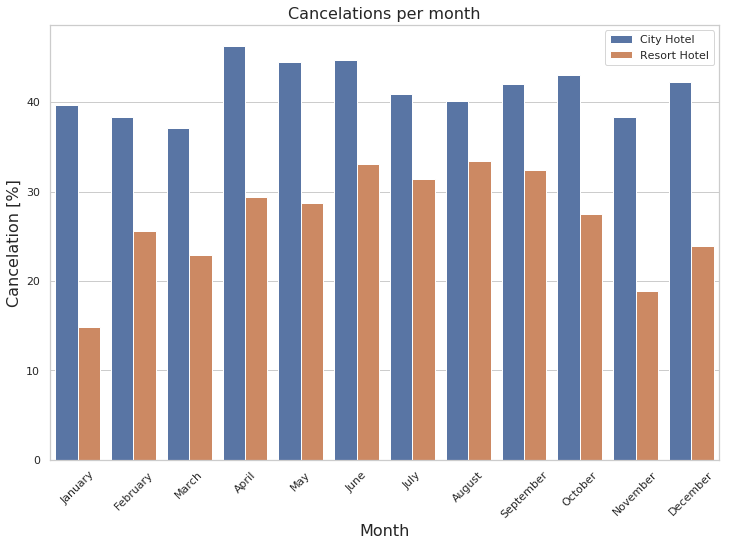

In [27]:
# 관련 데이터로 데이터 프레임 만들기:
res_book_per_month = full_data_cln.loc[(full_data_cln["hotel"] == "Resort Hotel")].groupby("arrival_date_month")["hotel"].count()
res_cancel_per_month = full_data_cln.loc[(full_data_cln["hotel"] == "Resort Hotel")].groupby("arrival_date_month")["is_canceled"].sum()

city_book_per_month = full_data_cln.loc[(full_data_cln["hotel"] == "City Hotel")].groupby("arrival_date_month")["hotel"].count()
city_cancel_per_month = full_data_cln.loc[(full_data_cln["hotel"] == "City Hotel")].groupby("arrival_date_month")["is_canceled"].sum()

res_cancel_data = pd.DataFrame({"Hotel": "Resort Hotel",
                                "Month": list(res_book_per_month.index),
                                "Bookings": list(res_book_per_month.values),
                                "Cancelations": list(res_cancel_per_month.values)})
city_cancel_data = pd.DataFrame({"Hotel": "City Hotel",
                                "Month": list(city_book_per_month.index),
                                "Bookings": list(city_book_per_month.values),
                                "Cancelations": list(city_cancel_per_month.values)})

full_cancel_data = pd.concat([res_cancel_data, city_cancel_data], ignore_index=True)
full_cancel_data["cancel_percent"] = full_cancel_data["Cancelations"]/full_cancel_data["Bookings"]*100


# order by month:
ordered_months = ["January", "February", "March", "April", "May", "June", 
          "July", "August", "September", "October", "November", "December"]
full_cancel_data["Month"] = pd.Categorical(full_cancel_data["Month"], categories = ordered_months, ordered=True)

# 그래프로 그리기
plt.figure(figsize=(12,8))
sns.barplot(x="Month", y="cancel_percent", hue="Hotel",
           hue_order = ["City Hotel","Resort Hotel"], data=full_cancel_data)
plt.title("Cancelations per month", fontsize= 16)
plt.xlabel("Month", fontsize= 16)
plt.xticks(rotation= 45)
plt.ylabel("Cancelation [%]",fontsize= 16)
plt.legend(loc="upper right")
plt.show()

In [28]:
full_data_cln.loc[(full_data_cln["hotel"] == "Resort Hotel")]["is_canceled"].mean()
full_data_cln.loc[(full_data_cln["hotel"] == "City Hotel")]["is_canceled"].mean()

0.4178593534858457

```
The City hotel 의 상대적인 취소 건수는 일년 내내 약 40%이다.
The Resort hotel은 여름에 가장 놓고 겨울에 가장 낮다.
```

## 2. Predict cancelations  (취소 예측)

Which numerical features are most important? (가장 중요한 특정 수치들은?)

In [29]:
cancel_corr = full_data.corr()["is_canceled"]
cancel_corr.abs().sort_values(ascending=False)[1:]

lead_time                         0.293123
total_of_special_requests         0.234658
required_car_parking_spaces       0.195498
booking_changes                   0.144381
previous_cancellations            0.110133
is_repeated_guest                 0.084793
agent                             0.083114
adults                            0.060017
previous_bookings_not_canceled    0.057358
days_in_waiting_list              0.054186
adr                               0.047557
babies                            0.032491
stays_in_week_nights              0.024765
company                           0.020642
arrival_date_year                 0.016660
arrival_date_week_number          0.008148
arrival_date_day_of_month         0.006130
children                          0.005048
stays_in_weekend_nights           0.001791
Name: is_canceled, dtype: float64

가장 중요한 수치 5가지 : lead_time, total_of_special_requests, required_car_parking_spaces, booking_changes and previous_cancellations

포함 않는 요소 : days_in_waiting_list & arrival_date_year

배제할 가장 중요한 요소 : reservation_status

예약 취소 여부 예측을 위해 예약 변경 횟수는 시간이 지남에 따라 변경 될수 있다.(leakage)

In [30]:
full_data.groupby("is_canceled")["reservation_status"].value_counts()

is_canceled  reservation_status
0            Check-Out             75166
1            Canceled              43017
             No-Show                1207
Name: reservation_status, dtype: int64

### Comparing different base models(다른 기본 모델 비교):

In [ ]:
full_data.info()

In [31]:
# 포함할 열 선택
# 모형을 보다 일반화하고 leakage를 방지 하기 위해 일부 열 제외
# (arrival_date_year, assigned_room_type, booking_changes, reservation_status, country,
# days_in_waiting_list)
# 국가를 포함하면 정확도가 향상되지만, 모델을 일번적이지 않게 만들 수 있다.

num_features = ["lead_time","arrival_date_week_number","arrival_date_day_of_month",
                "stays_in_weekend_nights","stays_in_week_nights","adults","children",
                "babies","is_repeated_guest", "previous_cancellations",
                "previous_bookings_not_canceled","agent","company",
                "required_car_parking_spaces", "total_of_special_requests", "adr"]

cat_features = ["hotel","arrival_date_month","meal","market_segment",
                "distribution_channel","reserved_room_type","deposit_type","customer_type"]

# feature와 예측값 분리
features = num_features + cat_features
X=full_data.drop(["is_canceled"], axis=1)[features]
y=full_data["is_canceled"]

# 숫자형 요소 전처리;
# 날짜를 제외한 대부분의 숫자에 대해 0은 fill value로 가장 논리적인 선택이 되며 여기에 결측값은 없다.
num_transformer = SimpleImputer(strategy ="constant")

# 범주형 요소에 대한 전처리:
cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="Unknown")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))])

# 숫자 및 범주형 요소에 대한 사전 Bundle처리:
preprocessor = ColumnTransformer(transformers=[("num", num_transformer, num_features),
                               ("cat", cat_transformer, cat_features)])

In [36]:
# Test 모델 정의 
base_models = [("DT_model", DecisionTreeClassifier(random_state=42)),
              ("RF_model", RandomForestClassifier(random_state=42, n_jobs=-1)),
              ("LR_model", LogisticRegression(random_state=42,n_jobs=-1)),
              ("XGB_model", XGBClassifier(random_state=42,n_jobs=-1))]

# 교차검증을 위한 데이터를 'Kfolds' 부분으로 분할
# 데이터의 random 분포를 위해 shuffle 사용:
kfolds = 4 # 4= 75% train, 25% validation
split = KFold(n_splits=kfolds, shuffle=True, random_state=42)

# 모든 모델에 대해 사전 처리, 적합, 예측 및 점수 매기기:
for name, model in base_models:
    # 데이터 및 모델의 사전 처리를 파이프라인으로 패키징
    model_steps = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('model',model)])
    
    # 각 모델에 대해 교차 검증 점수 
    cv_results = cross_val_score(model_steps,
                                X,y,
                                cv=split,
                                scoring="accuracy",
                                n_jobs=-1)
    
    # output:
    min_score = round(min(cv_results),4)
    max_score = round(max(cv_results),4)
    mean_score = round(np.mean(cv_results),4)
    std_dev = round(np.std(cv_results),4)
    print(f"{name} 교차 검증 정확도 점수: {mean_score} +/- {std_dev} (std)min: {min_score}, max:{max_score}")
    
    #pipeline.fit(X_train, y_train)
    #preds = pipeline.predict(X_valid)
    #score = accuracy_score(y_valid, preds)
    #print(f"{name} accuracy_score: {round(score, 4)}")

DT_model 교차 검증 정확도 점수: 0.8246 +/- 0.0016 (std)min: 0.8221, max:0.8263
RF_model 교차 검증 정확도 점수: 0.8664 +/- 0.0012 (std)min: 0.8646, max:0.8676
LR_model 교차 검증 정확도 점수: 0.7937 +/- 0.0012 (std)min: 0.792, max:0.7952
XGB_model 교차 검증 정확도 점수: 0.8165 +/- 0.0016 (std)min: 0.8139, max:0.8181


RandomForst 모델이 가장 성능이 좋음
하이퍼 파라미터 최적화도 수행했지만 정확도 증가는 미미함.

In [35]:
# 최고의 매개 변수를 가진 향상된 RF 모델
rf_model_enh = RandomForestClassifier(n_estimators=160,
                               max_features=0.4,
                               min_samples_split=2,
                               n_jobs=-1,
                               random_state=0)

split = KFold(n_splits=kfolds, shuffle=True, random_state=42)
model_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', rf_model_enh)])
cv_results = cross_val_score(model_pipe, 
                                 X, y, 
                                 cv=split,
                                 scoring="accuracy",
                                 n_jobs=-1)
# output:
min_score = round(min(cv_results), 4)
max_score = round(max(cv_results), 4)
mean_score = round(np.mean(cv_results), 4)
std_dev = round(np.std(cv_results), 4)
print(f"Enhanced RF model cross validation accuarcy score: {mean_score} +/- {std_dev} (std) min: {min_score}, max: {max_score}")

Enhanced RF model cross validation accuarcy score: 0.8681 +/- 0.0006 (std) min: 0.8673, max: 0.869


# 3. Evaluate Feature importance